In [1]:
# !pip install scikit-multilearn

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Stack Overflow: Tag Prediction

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h1> Exploratory Data Analysis </h1>

<h2> Data Loading and Cleaning </h2>

In [11]:
data_100k = pd.read_csv("Train_100k.csv")
data_100k.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [15]:
data_test_100k = pd.read_csv("Test_100k.csv")
data_test_100k.head()

,Id,Title,Body
0,6034196,Getting rid of site-specific hotkeys,<p>How do I disable site-specific hotkeys if (...
1,6034197,Nodes inside Cisco VPN. Incoming SSH requests ...,<p>I've a gateway-to-gateway VPN setup between...
2,6034198,Remove old vCenter servers from VMWare vSphere...,<p>After changing our vCenter servers recently...
3,6034199,Replace <span> element with var containing html,"<p>I have a variable i lifted the contents of,..."
4,6034200,Will PHP included html content affect my seo?,<p>Today i purchase a small CMS system. With t...


<h3> Checking for duplicates </h3>

In [16]:
import pandas as pd
from datetime import datetime

# Assuming `df` already contains the data from the database
start = datetime.now()

# Group by Title, Body, and Tags, and count duplicates
df_no_dup = data_100k.groupby(['Title', 'Body', 'Tags'], as_index=False).size().rename(columns={'size': 'cnt_dup'})

print("Time taken to run this cell:", datetime.now() - start)


Time taken to run this cell: 0:00:00.478844


In [17]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1
1,Encoding of sent data not working,"<p>I've got a little chatbox, everything's wor...",php jquery ajax encoding,1
2,"Files in Array, in Array to Tree?","<p>Using <code>C#</code>, I have created a pro...",c# visual-studio-2010 visual-studio-2008 clear...,1
3,Google Map location based on address,"<p>Im using Google Map in my application, it i...",android google-maps,1
4,How to insert custom field in typo3 Dam modul...,<p>I introduced my custom field in Dam modules...,typo3 dam,1


In [18]:
# Calculate the total number of rows in the original DataFrame
total_rows = len(data_100k)

# Calculate the number of duplicate questions
num_duplicates = total_rows - df_no_dup.shape[0]

# Calculate the percentage of duplicates
duplicate_percentage = (1 - (df_no_dup.shape[0] / total_rows)) * 100

# Print the result
print(f"Number of duplicate questions: {num_duplicates} ({duplicate_percentage:.2f}%)")


Number of duplicate questions: 564 (0.56%)


In [19]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    98874
2      560
3        2
Name: cnt_dup, dtype: int64

In [20]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.023232


,Title,Body,Tags,cnt_dup,tag_count
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1,2
1,Encoding of sent data not working,"<p>I've got a little chatbox, everything's wor...",php jquery ajax encoding,1,4
2,"Files in Array, in Array to Tree?","<p>Using <code>C#</code>, I have created a pro...",c# visual-studio-2010 visual-studio-2008 clear...,1,4
3,Google Map location based on address,"<p>Im using Google Map in my application, it i...",android google-maps,1,2
4,How to insert custom field in typo3 Dam modul...,<p>I introduced my custom field in Dam modules...,typo3 dam,1,2


In [21]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    28603
2    26384
4    19009
1    13784
5    11656
Name: tag_count, dtype: int64

<h2> Analysis of Tags </h2>

<h3>Total number of unique tags </h3>

In [22]:

vectorizer = CountVectorizer(tokenizer = lambda x: x.split())

tag_dtm = vectorizer.fit_transform(df_no_dup['Tags'])

In [23]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 99436
Number of unique tags : 18448


In [24]:
# Use get_feature_names_out() instead of get_feature_names()
tags = vectorizer.get_feature_names_out()

# Let's look at the tags we have
print("Some of the tags we have:", tags[:10])


Some of the tags we have: ['.a' '.bash-profile' '.class-file' '.each' '.emf' '.hgtags' '.htaccess'
 '.htpasswd' '.mov' '.net']


<h3>Number of times a tag appeared </h3>

In [25]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [26]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,2
1,.bash-profile,1
2,.class-file,1
3,.each,6
4,.emf,2


In [27]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

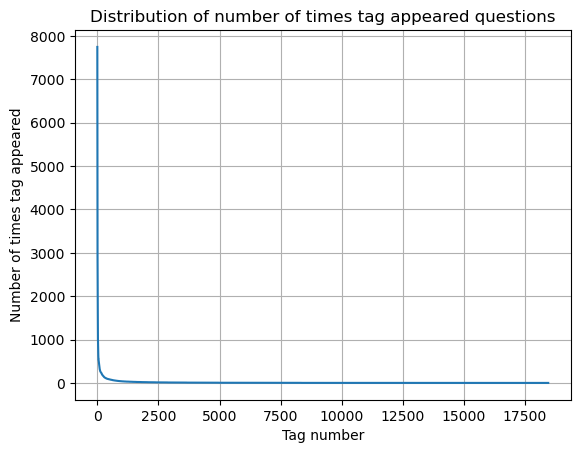

In [28]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

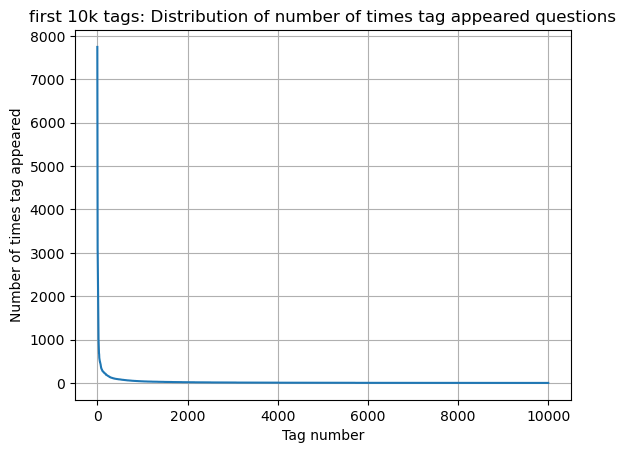

400 [7745  996  538  412  314  264  237  218  188  171  156  138  126  119
  110  104   97   93   90   85   83   79   75   73   69   66   64   60
   59   56   54   52   50   48   47   45   44   42   41   40   39   37
   37   36   35   34   33   32   32   31   31   30   29   29   28   28
   27   27   26   26   25   25   24   24   23   23   23   22   22   21
   21   21   20   20   20   20   19   19   19   18   18   18   18   17
   17   17   17   16   16   16   16   15   15   15   15   15   14   14
   14   14   14   13   13   13   13   13   13   13   12   12   12   12
   12   12   12   11   11   11   11   11   11   11   11   11   10   10
   10   10   10   10   10   10   10   10   10    9    9    9    9    9
    9    9    9    9    9    9    9    8    8    8    8    8    8    8
    8    8    8    8    8    8    8    7    7    7    7    7    7    7
    7    7    7    7    7    7    7    7    7    7    7    6    6    6
    6    6    6    6    6    6    6    6    6    6    6    6    6    6
  

In [29]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

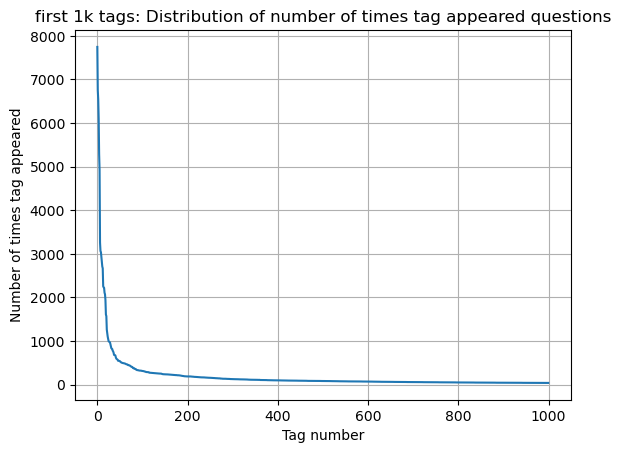

200 [7745 4925 2818 2222 1570  996  879  763  669  571  538  499  486  465
  444  412  379  357  331  322  314  300  287  274  268  264  260  255
  252  240  237  234  229  224  219  218  214  207  200  191  188  187
  183  178  175  171  167  166  162  159  156  153  150  147  143  138
  135  134  130  128  126  125  123  121  120  119  118  115  112  111
  110  109  109  106  105  104  102  100   99   98   97   97   96   95
   94   93   92   92   91   90   90   89   89   87   86   85   85   84
   84   83   83   82   81   81   80   79   78   77   76   76   75   74
   74   74   73   73   72   72   70   70   69   69   68   68   67   66
   65   65   65   64   64   63   62   61   61   60   60   59   59   59
   59   58   58   57   57   56   56   56   55   55   54   54   53   53
   52   52   51   51   51   50   50   50   49   49   49   48   48   47
   47   47   47   46   46   46   45   45   45   44   44   44   44   44
   43   43   43   42   42   42   42   41   41   41   40   40   40   40
  

In [30]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

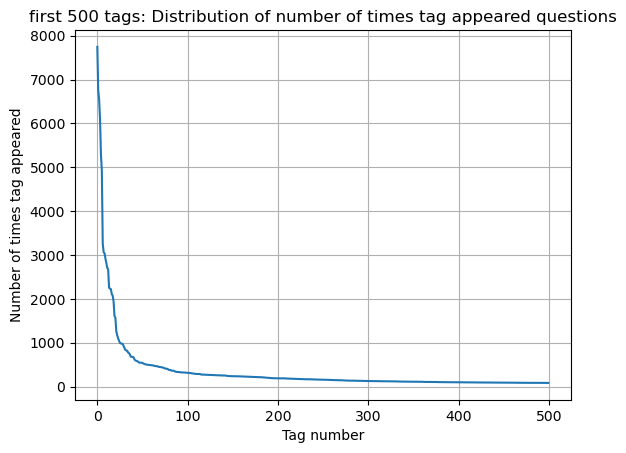

100 [7745 4925 2818 2222 1570  996  879  763  669  571  538  499  486  465
  444  412  379  357  331  322  314  300  287  274  268  264  260  255
  252  240  237  234  229  224  219  218  214  207  200  191  188  187
  183  178  175  171  167  166  162  159  156  153  150  147  143  138
  135  134  130  128  126  125  123  121  120  119  118  115  112  111
  110  109  109  106  105  104  102  100   99   98   97   97   96   95
   94   93   92   92   91   90   90   89   89   87   86   85   85   84
   84   83]


In [31]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

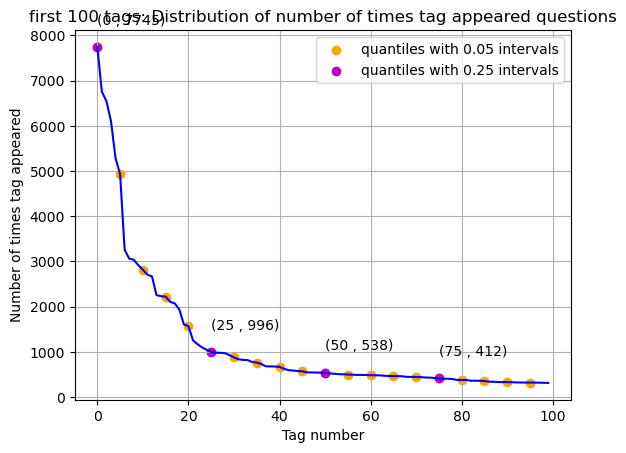

20 [7745 4925 2818 2222 1570  996  879  763  669  571  538  499  486  465
  444  412  379  357  331  322]


In [32]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x, y in zip(list(range(0, 100, 25)), tag_counts[0:100:25]):
    plt.annotate("({} , {})".format(x, y), xy=(x, y), xytext=(x - 0.05, y + 500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

<h3> Tags Per Question </h3>

In [33]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 99436 datapoints.
[2, 4, 4, 2, 2]


In [34]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.883030


<h3> Most Frequent Tags </h3>

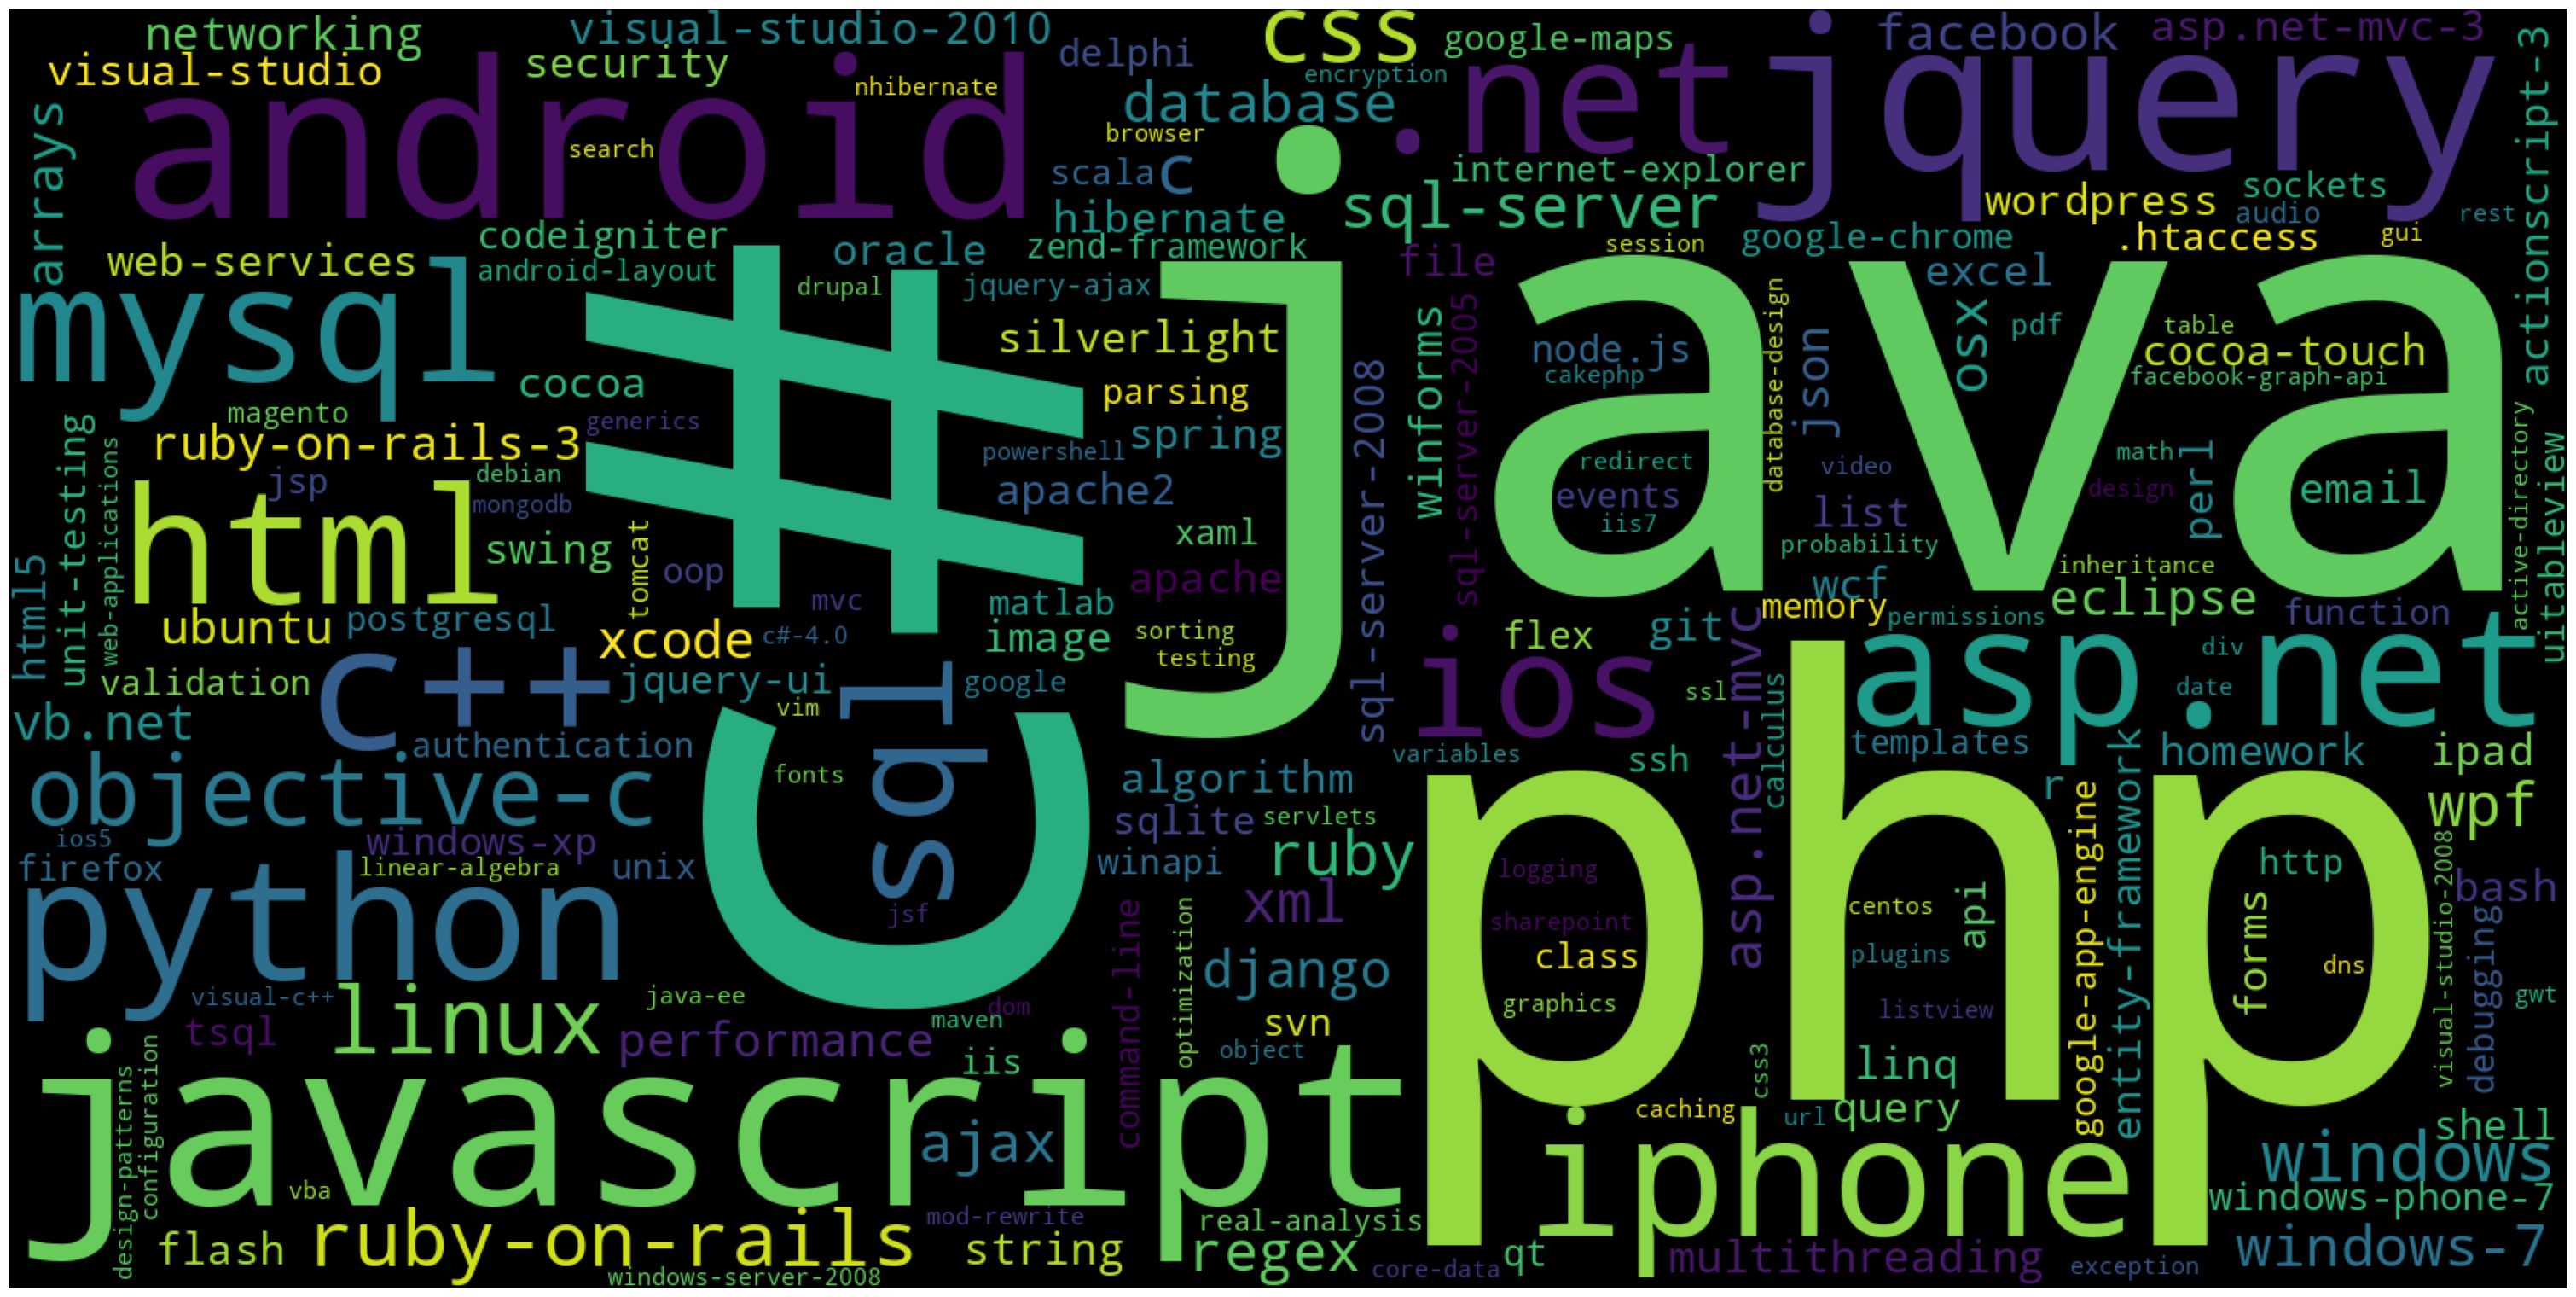

Time taken to run this cell : 0:00:07.326210


In [36]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> The top 20 tags </h3>

In [35]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)

In [36]:
tag_df_sorted.head()

,Tags,Counts
2010,c#,7745
8044,java,6753
11936,php,6545
8086,javascript,6102
569,android,5287


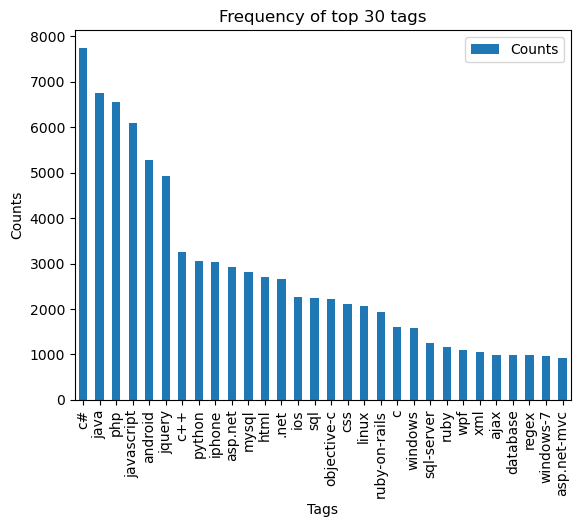

In [37]:
i = np.arange(30)  # 30 positions
top_30_tags = tag_df_sorted.head(30)  # Top 30 rows

top_30_tags.plot(kind='bar')
plt.title('Frequency of top 30 tags')  # Adjust the title for 30 tags
plt.xticks(i, top_30_tags['Tags'], rotation=90)  # Ensure the number of ticks and labels match
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, python and java are among the top most frequent operating systems.

<h3> Cleaning and preprocessing of Questions </h3>

<h3> Preprocessing </h3>

In [38]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuktamuthreja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [40]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yuktamuthreja/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [86]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stemmer and stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def striphtml(data):
    # HTML stripping function (you may want to use BeautifulSoup for more robust HTML parsing)
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', data.decode('utf-8'))
    return cleantext

def process_dataframe(df):
    # Initialize counters and tracking variables
    questions_processed = 0
    questions_with_code = 0
    len_pre = 0
    len_post = 0
    processed_data = []

    for index, row in df.iterrows():
        title = row['Title']
        question = row['Body']
        tags = row['Tags']

        # Check for code presence
        is_code = 1 if '<code>' in question else 0
        if is_code:
            questions_with_code += 1

        # Calculate pre-processing length
        x = len(str(question)) + len(str(title))
        len_pre += x

        # Extract and remove code blocks
        code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
        question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)

        # Strip HTML and combine title and body
        question = striphtml(question.encode('utf-8'))
        title = title.encode('utf-8')
        combined_text = str(title) + " " + str(question)

        # Text processing
        combined_text = re.sub(r'[^A-Za-z]+', ' ', combined_text)
        words = word_tokenize(combined_text.lower())

        # Stemming and stop word removal
        processed_text = ' '.join(
            stemmer.stem(j) for j in words
            if j not in stop_words and (len(j) != 1 or j == 'c')
        )

        # Track post-processing length
        len_post += len(processed_text)
        questions_processed += 1

        # Prepare processed row
        processed_data.append({
            'question': processed_text,
            'code': code,
            'tags': tags,
            'words_pre': x,
            'words_post': len(processed_text),
            'is_code': is_code
        })

        # Optional: Print progress
        if questions_processed % 100000 == 0:
            print(f"Number of questions completed = {questions_processed}")

    # Create processed DataFrame
    processed_df = pd.DataFrame(processed_data)

    # Calculate statistics
    no_dup_avg_len_pre = len_pre / questions_processed
    no_dup_avg_len_post = len_post / questions_processed
    percent_code_questions = (questions_with_code * 100.0) / questions_processed

    print(f"Avg. length of questions(Title+Body) before processing: {no_dup_avg_len_pre:.2f}")
    print(f"Avg. length of questions(Title+Body) after processing: {no_dup_avg_len_post:.2f}")
    print(f"Percent of questions containing code: {percent_code_questions:.2f}%")

    return processed_df

# Read the CSV file in chunks
chunksize = 10000  # Adjust as needed
index_start = 0
processed_chunks = []

for chunk in pd.read_csv('Train_100k.csv', names=['Id', 'Title', 'Body', 'Tags'],
                         chunksize=chunksize, encoding='utf-8'):
    # Process the chunk
    processed_chunk = process_dataframe(chunk)
    processed_chunks.append(processed_chunk)

    # Update index for next chunk
    index_start += len(chunk)

# Combine processed chunks
final_processed_df = pd.concat(processed_chunks, ignore_index=True)
final_processed_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuktamuthreja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuktamuthreja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Avg. length of questions(Title+Body) before processing: 1158.51
Avg. length of questions(Title+Body) after processing: 327.51
Percent of questions containing code: 55.88%
Avg. length of questions(Title+Body) before processing: 1156.39
Avg. length of questions(Title+Body) after processing: 323.88
Percent of questions containing code: 55.52%
Avg. length of questions(Title+Body) before processing: 1176.57
Avg. length of questions(Title+Body) after processing: 326.44
Percent of questions containing code: 56.25%
Avg. length of questions(Title+Body) before processing: 1134.88
Avg. length of questions(Title+Body) after processing: 325.28
Percent of questions containing code: 54.91%
Avg. length of questions(Title+Body) before processing: 1130.47
Avg. length of questions(Title+Body) after processing: 327.66
Percent of questions containing code: 56.20%
Avg. length of questions(Title+Body) before processing: 1156.54
Avg. length of questions(Title+Body) after processing: 326.21
Percent of question

,question,code,tags,words_pre,words_post,is_code
0,titl bodi,[],Tags,9,9,0
1,check upload file imag without mime type like ...,[],php image-processing file-upload upload mime-t...,471,271,0
2,prevent firefox close press ctrl favorit edito...,[],firefox,418,239,0
3,error invalid type list variabl import matlab ...,"[""Error in model.frame.default(formula = exper...",r matlab machine-learning,13572,268,1
4,replac special charact url probabl simpl simpl...,[],c# url encoding,607,273,0


In [78]:
final_processed_df = final_processed_df[['question','tags']]


In [79]:
final_processed_df.head()

,question,tags
0,titl bodi,Tags
1,check upload file imag without mime type like ...,php image-processing file-upload upload mime-t...
2,prevent firefox close press ctrl favorit edito...,firefox
3,error invalid type list variabl import matlab ...,r matlab machine-learning
4,replac special charact url probabl simpl simpl...,c# url encoding


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuktamuthreja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Tag and Question Word Frequency Comparison:
       Tag  Tag_Frequency  Question_Word_Frequency
        c#           7786                        0
      java           6788                    11480
       php           6575                    12936
javascript           6135                     7097
   android           5317                     7798
    jquery           4949                        0
       c++           3278                        0
    python           3082                     5249
    iphone           3050                        0
   asp.net           2937                        0


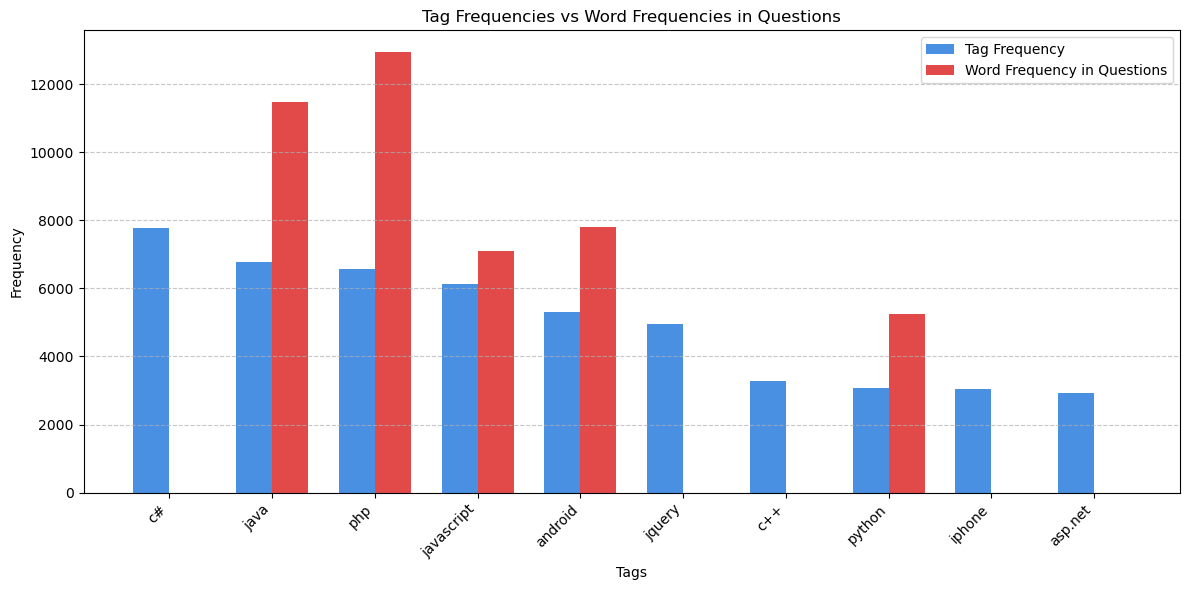

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def analyze_tags_and_text(df):
    # Process tags
    all_tags = []
    for tags in df['tags'].dropna():
        # Split tags on spaces since they appear space-separated in the image
        tag_list = str(tags).split()
        all_tags.extend(tag_list)
    
    # Get top 10 most common tags (adjusting to show fewer for better readability)
    tag_counts = Counter(all_tags).most_common(10)
    tag_words = [tag for tag, _ in tag_counts]
    tag_frequencies = [count for _, count in tag_counts]
    
    # Process question text
    all_words = []
    for text in df['question'].dropna():
        words = word_tokenize(str(text).lower())
        # Filter out special characters and single characters
        words = [word for word in words if word.isalnum() and len(word) > 1]
        all_words.extend(words)
    
    # Get word frequencies for the same words as in tags
    word_counts = Counter(all_words)
    word_frequencies = [word_counts[word.lower()] for word in tag_words]
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    x = np.arange(len(tag_words))
    width = 0.35
    
    plt.bar(x - width/2, tag_frequencies, width, label='Tag Frequency', color='#4a90e2')
    plt.bar(x + width/2, word_frequencies, width, label='Word Frequency in Questions', color='#e24a4a')
    
    plt.xlabel('Tags')
    plt.ylabel('Frequency')
    plt.title('Tag Frequencies vs Word Frequencies in Questions')
    plt.xticks(x, tag_words, rotation=45, ha='right')
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Return the data for analysis
    comparison_df = pd.DataFrame({
        'Tag': tag_words,
        'Tag_Frequency': tag_frequencies,
        'Question_Word_Frequency': word_frequencies
    })
    
    return comparison_df

# Read and analyze the data
result_df = analyze_tags_and_text(final_processed_df)

# Display the results
print("\nTag and Question Word Frequency Comparison:")
print(result_df.to_string(index=False))

In [85]:
result_df[result_df['Question_Word_Frequency'] > 0]

,Tag,Tag_Frequency,Question_Word_Frequency
1,java,6788,11480
2,php,6575,12936
3,javascript,6135,7097
4,android,5317,7798
7,python,3082,5249


In [43]:
print("number of data points in sample :", final_processed_df.shape[0])
print("number of dimensions :", final_processed_df.shape[1])

number of data points in sample : 100001
number of dimensions : 2


<h1> Machine Learning Models </h1>

<h2> Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [44]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
multilabel_y = vectorizer.fit_transform(final_processed_df['tags'])

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [45]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [46]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=final_processed_df.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

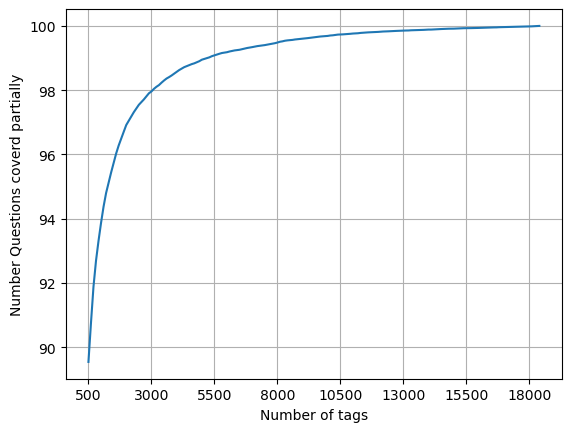

with  5500 tags we are covering  99.083 % of questions


In [47]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [48]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 917 out of  100001


In [49]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 18448
number of tags taken : 500 ( 2.7103209019947965 %)


__ We consider top 15% tags which covers  99% of the questions __

<h2>4.2 Split the data into test and train (80:20) </h2>

In [50]:
final_processed_df.head()

,question,tags
0,titl bodi,Tags
1,check upload file imag without mime type like ...,php image-processing file-upload upload mime-t...
2,prevent firefox close press ctrl favorit edito...,firefox
3,error invalid type list variabl import matlab ...,r matlab machine-learning
4,replac special charact url probabl simpl simpl...,c# url encoding


In [51]:
total_size=final_processed_df.shape[0]
train_size=int(0.80*total_size)

x_train=final_processed_df.head(train_size)
x_test=final_processed_df.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [52]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 500)
Number of data points in test data : (20001, 500)


<h3> Featurizing data with count vectorizer(BoW) </h3>

In [53]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=20000, tokenizer=lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:27.498867


In [54]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 20000) Y : (80000, 500)
Dimensions of test data X: (20001, 20000) Y: (20001, 500)


In [85]:


from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Define the model with corrected loss
classifier = OneVsRestClassifier(SGDClassifier(loss='log_loss', penalty='l1'))



In [63]:
from scipy import sparse
from sklearn import metrics
from datetime import datetime

# Preprocess matrices
x_train_multilabel = sparse.csr_matrix(x_train_multilabel.toarray())
x_test_multilabel = sparse.csr_matrix(x_test_multilabel.toarray())

start = datetime.now()

# Define the classifier with the corrected loss parameter
classifier = OneVsRestClassifier(SGDClassifier(loss='log_loss', alpha=0.0001, penalty='l1'), n_jobs=-1)

# Fit the classifier
classifier.fit(x_train_multilabel, y_train)

# Make predictions
predictions = classifier.predict(x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1488925553722314
Hamming loss  0.003871506424678766
Micro-average quality numbers
Precision: 0.4538, Recall: 0.4101, F1-measure: 0.4309
Macro-average quality numbers
Precision: 0.3377, Recall: 0.3350, F1-measure: 0.3242
Time taken to run this cell : 0:00:55.505605


In [64]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1454927253637318
Hamming loss  0.003932803359832008
Micro-average quality numbers
Precision: 0.4454, Recall: 0.4105, F1-measure: 0.4272
Macro-average quality numbers
Precision: 0.3221, Recall: 0.3351, F1-measure: 0.3178
Time taken to run this cell : 0:00:59.281920


In [ ]:
param={'estimator__alpha': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge',alpha=0.001, penalty='l1'))
gsv = GridSearchCV(estimator = classifier, param_grid=param, cv=3, verbose=0, scoring='f1_micro',n_jobs=15)
gsv.fit(x_train_multilabel, y_train)

param={'estimator__alpha': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))
gsv = GridSearchCV(estimator = classifier, param_grid=param, cv=3, verbose=0, scoring='f1_micro',n_jobs=15)
gsv.fit(x_train_multilabel, y_train)

best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
print('value of alpha after hyperparameter tuning : ',best_alpha)
print('-------------------------------------------------------------')

In [73]:
# Get the original tag names from the vectorizer
#tag_names = vectorizer.get_feature_names_out()

def get_predicted_tags(prediction_matrix, tag_names, top_k=5):
    predicted_tags_list = []
    # Convert sparse matrix to dense array if it's sparse
    if sparse.issparse(prediction_matrix):
        prediction_matrix = prediction_matrix.toarray()
    
    for row in prediction_matrix:
        # Find indices of tags that were predicted as 1
        predicted_tag_indices = np.where(row == 1)[0]
        
        # Map these indices to tag names
        predicted_tags = [tag_names[idx] for idx in predicted_tag_indices]
        
        predicted_tags_list.append(predicted_tags)
    
    return predicted_tags_list

# Get the tag names 
tag_names = np.array(vectorizer.get_feature_names_out())

# Get the predicted tags
predicted_tags = get_predicted_tags(predictions, tag_names)

# If you want to see some examples
print("First 5 sets of predicted tags:")
for tags in predicted_tags[:5]:
    print(tags)

# Similar modification for actual tags function
def get_actual_tags(y_test_matrix, tag_names):
    actual_tags_list = []
    # Convert sparse matrix to dense array if it's sparse
    if sparse.issparse(y_test_matrix):
        y_test_matrix = y_test_matrix.toarray()
    
    for row in y_test_matrix:
        # Find indices of tags that are 1
        actual_tag_indices = np.where(row == 1)[0]
        
        # Map these indices to tag names
        actual_tags = [tag_names[idx] for idx in actual_tag_indices]
        
        actual_tags_list.append(actual_tags)
    
    return actual_tags_list

# Get actual tags
actual_tags = get_actual_tags(y_test, tag_names)

print("\nFirst 5 sets of actual tags:")
for tags in actual_tags[:10]:
    print(tags)

# Optional: Comparison
print("\nComparing Predicted vs Actual Tags:")
for pred, actual in zip(predicted_tags[:10], actual_tags[:10]):
    print(f"Predicted: {pred}")
    print(f"Actual:    {actual}")
    print("---")

First 5 sets of predicted tags:
['add use', 'alloc memori']
['ad follow']
['ab']
['administr account']
['abl open', 'account use', 'add page']

First 5 sets of actual tags:
['abc']
['aa', 'abelian group']
['ab']
['aa', 'abelian group', 'administr account', 'allow use']
['abbrevi', 'abelian', 'abl', 'abl open', 'adb']
['add button']
['abl access', 'abl move']
['ab', 'abl use']
[]
['aa']

Comparing Predicted vs Actual Tags:
Predicted: ['add use', 'alloc memori']
Actual:    ['abc']
---
Predicted: ['ad follow']
Actual:    ['aa', 'abelian group']
---
Predicted: ['ab']
Actual:    ['ab']
---
Predicted: ['administr account']
Actual:    ['aa', 'abelian group', 'administr account', 'allow use']
---
Predicted: ['abl open', 'account use', 'add page']
Actual:    ['abbrevi', 'abelian', 'abl', 'abl open', 'adb']
---
Predicted: ['also problem']
Actual:    ['add button']
---
Predicted: ['abl access', 'across multipl']
Actual:    ['abl access', 'abl move']
---
Predicted: ['ab', 'abl use', 'add addit']
A

In [2]:
# !pip install pandas tqdm subprocess

In [85]:

from tqdm import tqdm
import subprocess
from sklearn.model_selection import train_test_split

In [101]:
# def generate_batch_prompt(few_shot_examples, questions):
#     prompt = """You are a programming question tagger. For each question, assign 3-4 relevant programming tags.
# Format MUST be EXACTLY as shown below - no additional text, no explanations:

# Question 1: tag1: parsing, tag2: string, tag3: date
# Question 2: tag1: windows, tag2: filesystem, tag3: io
# Question 3: tag1: algorithms, tag2: complexity, tag3: proofs

# Actual examples with proper tags:
# """
#     # Add few shot examples
#     for i, row in enumerate(few_shot_examples.iterrows(), 1):
#         tags = row[1]['tags'].split(',')[:3]  # Get first 3 tags
#         prompt += f"Question {i}:"
#         for j, tag in enumerate(tags, 1):
#             prompt += f" tag{j}: {tag.strip()},"
#         prompt += "\n"

#     prompt += "\nTag these questions using EXACTLY the same format:\n"
#     for i, q in enumerate(questions, 1):
#         prompt += f"{i}. {q}\n"
    
#     return prompt

# def query_ollama(prompt, timeout=60):
#     """Simple function to query Ollama and return the raw response"""
#     try:
#         result = subprocess.run(
#             ["ollama", "run", "llama2"],
#             input=prompt,
#             text=True,
#             capture_output=True,
#             timeout=timeout
#         )
#         response = result.stdout.strip()
#         print("\nRaw response:", response)
#         return response
        
#     except Exception as e:
#         print(f"Error in querying Ollama: {e}")
#         return None

# def parse_tags_from_response(response_text):
#     """Parse the response to extract tags for each question"""
#     tag_sets = []
#     current_tags = []
    
#     lines = response_text.split('\n')
#     for line in lines:
#         line = line.strip()
#         if line.startswith('Question') and current_tags:
#             # Save previous question's tags
#             tag_sets.append(', '.join(current_tags))
#             current_tags = []
            
#         # Look for tag1:, tag2:, etc.
#         if 'tag' in line and ':' in line:
#             try:
#                 # Extract tag value after colon and comma
#                 tag_value = line.split(':')[1].split(',')[0].strip()
#                 if tag_value and not tag_value.startswith('tag'):
#                     current_tags.append(tag_value)
#             except IndexError:
#                 continue
    
#     # Add the last question's tags
#     if current_tags:
#         tag_sets.append(', '.join(current_tags))
    
#     return tag_sets

# def process_batch(test_data, few_shot_examples, batch_size=3):
#     """Process a batch of questions and return results DataFrame"""
#     results = []
    
#     for i in range(0, len(test_data), batch_size):
#         batch = test_data.iloc[i:i+batch_size]
#         questions = batch['question'].tolist()
        
#         # Generate prompt
#         prompt = generate_batch_prompt(few_shot_examples, questions)
#         print("\nProcessing batch...")
#         print("Number of questions:", len(questions))
        
#         # Get model response
#         response = query_ollama(prompt)
#         if response:
#             print("\nRaw response:", response)
            
#             # Parse predictions
#             predicted_tags = parse_tags_from_response(response)
#             print("\nParsed tag sets:", predicted_tags)
            
#             if len(predicted_tags) == len(questions):
#                 # Create DataFrame entries
#                 for q, a, p in zip(questions, batch['tags'], predicted_tags):
#                     results.append({
#                         "Question": q,
#                         "Actual_Tags": a,
#                         "Predicted_Tags": p
#                     })
#                 print("\nSuccessfully processed batch")
#             else:
#                 print(f"\nMismatch in predictions: expected {len(questions)}, got {len(predicted_tags)}")
    
#     return pd.DataFrame(results)

# if __name__ == "__main__":
#     # Split data
#     train_data, test_data = train_test_split(final_processed_df, test_size=0.2, random_state=42)
    
#     # Select few-shot examples
#     few_shot_examples = train_data.sample(n=5, random_state=42)
    
#     # Process small test set
#     test_subset = test_data.head(3)
    
#     print("Starting processing...")
#     print(f"Few-shot examples: {len(few_shot_examples)}")
#     print(f"Test questions: {len(test_subset)}")
    
#     # Process the data
#     results_df = process_batch(test_subset, few_shot_examples, batch_size=3)
    
#     if not results_df.empty:
#         print("\nFinal Results:")
#         print(results_df)
#         results_df.to_csv("tag_predictions.csv", index=False)
#     else:
#         print("\nNo results generated. Check the output above.")

Starting processing...
Few-shot examples: 5
Test questions: 3

Processing batch...
Number of questions: 3

Raw response: 1. tag1: parsing, tag2: string, tag3: date
read nsdate string string date want pars nsdate object way look nsdate nsscanner seen anyth would read string
2. tag1: windows, tag2: filesystem, tag3: io
user writabl space window xp part window xp filesystem alway writabl regardless type permiss public machin local librari comput lock ie would love use portabl firefox view internet properli flash drive load onto time leav home
3. tag1: algorithms, tag2: complexity, tag3: proofs
co np assert want prove assert fals given co np cap np alreadi know co np close intersect union result use sinc membership co np exclud membership np tri figur thing work differ case co np cap np trivial true co np cap np co np setminu np co np setminu np word co np setminu np close intersect way prove incorrect assert provid counterexampl thank nb assum neq sinc want gener case
4. tag1: exception-h

##  Using a pre-trained model to generate the tags

In [41]:
import pandas as pd
import subprocess

# Function to generate the prompt with few-shot examples and questions
def generate_prompt(few_shot_examples, questions):
    prompt = """You are a programming question tagger. For each question, assign 3-4 relevant programming tags separated by commas, and separate tag sets for each question by |.
For example:
python, scripting, programming 
image-processing, file-upload, graphics 
database, optimization, queries 

Actual examples with proper tags:
"""
    # Add few-shot examples
    for _, row in few_shot_examples.iterrows():
        tags = row['tags'].replace(", ", ",")  # Ensure consistent formatting
        prompt += f"{tags} |\n"

    # Append the questions
    prompt += "\nGenerate tags for the following questions:\n"
    for question in questions:
        prompt += f"{question}\n"

    print("\nGenerated Prompt:\n", prompt)  # Debug: Show the prompt
    return prompt

# Query the Ollama model
def query_ollama(prompt, timeout=60):
    try:
        print("\nQuerying Ollama with prompt...")  # Debug
        result = subprocess.run(
            ["ollama", "run", "llama2"],
            input=prompt,
            text=True,
            capture_output=True,
            timeout=timeout
        )
        response = result.stdout.strip()
        print("\nRaw response:\n", response)  # Debug
        return response
    except Exception as e:
        print(f"Error in querying Ollama: {e}")
        return None

# Function to parse and append tags to the results DataFrame
def append_tags_to_dataframe(raw_response, questions, results_df):
    # Split the raw response by lines
    raw_tags_lines = raw_response.strip().split("\n")

    # Initialize lists to hold questions and tags
    questions_list = []
    tags_list = []

    # Process each line in the raw response
    for line in raw_tags_lines:
        # Split by the "|" character to separate question and tags
        parts = line.split("|")
        if len(parts) == 2:  # Ensure there is a question and tags
            question_text = parts[0].strip()
            tags = parts[1].strip()
            
            # Append the question and tags to the respective lists
            questions_list.append(question_text)
            tags_list.append(tags)

    # Ensure that the number of questions and tags match
    if len(questions_list) != len(questions):
        print("Mismatch in the number of questions and tags.")
        return results_df

    # Create a dictionary of question and its corresponding tags
    new_data = {'question': questions_list, 'tags': tags_list}

    # Convert to DataFrame
    new_df = pd.DataFrame(new_data)

    # Append to results_df
    results_df = pd.concat([results_df, new_df], ignore_index=True)
    
    return results_df

# Main processing function
def process_questions(questions, few_shot_examples, results_df):
    # Generate the prompt
    prompt = generate_prompt(few_shot_examples, questions)
    
    # Query the model
    response = query_ollama(prompt)
    if response:
        # Parse and append tags to the DataFrame
        results_df = append_tags_to_dataframe(response, questions, results_df)
        return results_df
    else:
        print("No response received from the model.")
        return results_df

# Main execution
if __name__ == "__main__":

    final_processed_df = final_processed_df.head(15)

    # Select few-shot examples from the dataset
    few_shot_examples = final_processed_df.sample(n=3, random_state=42)  # Adjust sample size if needed
    print("Few-shot examples selected:\n", few_shot_examples)  # Debug

    # List of questions to process
    questions = final_processed_df['question'].tolist()

    # Initialize an empty DataFrame for the results
    results_df = pd.DataFrame(columns=['question', 'tags'])

    # Generate tags for the questions
    results_df = process_questions(questions, few_shot_examples, results_df)

    # Print the results DataFrame
    print("\nUpdated Results DataFrame:\n", results_df)


Few-shot examples selected:
                                             question  \
8  fetch xml feed use asp net decid convert windo...   
1  check upload file imag without mime type like ...   
5  modifi whoi contact detail use modifi function...   

                                                tags  
8                         c# asp.net windows-phone-7  
1  php image-processing file-upload upload mime-t...  
5                          php api file-get-contents  

Generated Prompt:
 You are a programming question tagger. For each question, assign 3-4 relevant programming tags separated by commas, and separate tag sets for each question by |.
For example:
python, scripting, programming 
image-processing, file-upload, graphics 
database, optimization, queries 

Actual examples with proper tags:
c# asp.net windows-phone-7 |
php image-processing file-upload upload mime-types |
php api file-get-contents |

Generate tags for the following questions:
titl bodi
check upload file imag wit

python(83494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Raw response:
 Here are the programming tags for each question:

1. titl bodi | tag: python, html,css
2. check upload file imag without mime type like check upload file imag file png jpg jpeg gif bmp anoth file problem use uploadifi upload file chang mime type give text octal someth mime type matter file type upload way check upload file imag apart check file extens use php | tag: php,image-processing,file-upload
3. prevent firefox close press ctrl favorit editor vim regularli use ctrl execut certain action quit often happen firefox activ window window still look vim think vim activ window press ctrl close firefox want way stop ctrl close firefox rene | tag: python,javascript,firefox
4. error invalid type list variabl import matlab file construct data frame matlab file contain two column row maintain cell matrix construct datafram run random forest get follow error code import matlab file construct datafram structur matlab input file load matlab file | tag: matlab,python,import
5. rep